### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [53]:
import pandas as pd

# Bank Marketing

## 1) Business Understanding
### Objective:
#### The classification goal is to predict if the client will subscribe a term deposit

### Key Questions:
#### What are the target market segment for the Portuguese banking institution, and what shoud be customer retention policies

### Success Criteria:
#### Provide options to the Portuguese banking institution to optimize its marketing strategies, reduce costs, and increase the conversion rates of their marketing campaigns, thereby improving overall profitability

## 2) Data Understanding

## 2.1 Data Collection

The data is related with direct marketing campaigns of a Portuguese banking institution. 
   The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, 
   in order to access if the product (bank term deposit) would be (or not) subscribed.

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# Fetch the dataset
bank_marketing = fetch_ucirepo(id=222)

  
# data (as pandas dataframes) 
df = pd.DataFrame(bank_marketing.data.features)
df['target'] = bank_marketing.data.targets 


# Display the first few rows and basic information
print(df.head())
print(df.info())
print(df['target'].value_counts())  # Check the distribution of the target variable


   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married        NaN      no     1506     yes   no   
4   33           NaN   single        NaN      no        1      no   no   

  contact  day_of_week month  duration  campaign  pdays  previous poutcome  \
0     NaN            5   may       261         1     -1         0      NaN   
1     NaN            5   may       151         1     -1         0      NaN   
2     NaN            5   may        76         1     -1         0      NaN   
3     NaN            5   may        92         1     -1         0      NaN   
4     NaN            5   may       198         1     -1         0      NaN   

  target  
0     no  
1     no  
2     no  
3     no  
4     no  
<class 'pandas.core.

Total number of dataset : 45,211

Total number of features : 16

Target variable : has the client subscribed a term deposit? (binary: "yes","no")

## 2.2 Exploratory Data Analysis (EDA)

In [3]:
# To make data exploration easie for the first iteration, I am just loading 10,00 random rows into a dataframe

customer_sample = df.sample(n=10000)

# Explore the dataset
print(customer_sample.head())
print(customer_sample.info())
print(customer_sample.describe())


       age            job  marital  education default  balance housing loan  \
13496   29     technician  married  secondary      no      492     yes   no   
16143   30    blue-collar  married  secondary      no      791     yes  yes   
33478   43  self-employed  married  secondary      no     5564      no   no   
42107   32     technician   single   tertiary      no      600      no   no   
20524   39     technician  married  secondary      no     1986      no   no   

        contact  day_of_week month  duration  campaign  pdays  previous  \
13496  cellular            9   jul       259         1     -1         0   
16143  cellular           22   jul       137         2     -1         0   
33478  cellular           20   apr        45         5    154         2   
42107  cellular            2   nov       272         1     -1         0   
20524  cellular           12   aug       217         6     -1         0   

      poutcome target  
13496      NaN     no  
16143      NaN     no  
33

## 2.2 Prepeare the data from modelling

In [32]:
 # handle categorical variables, scaling numerical features, and splitting the data.
    
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Split the data into features and target
X = df.drop('target', axis=1)
y = df['target']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Standardize numerical features
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # One-Hot encode categorical features
    ]
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# 4. Modeling

In [5]:
# Build and evaluate models using different classifiers within pipelines.

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Define classifiers
classifiers = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(probability=True)
}

# Store results
results = {}

# Evaluate each classifier
for name, clf in classifiers.items():
    # Create a pipeline with preprocessing and the classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Store the results
    results[name] = {
        'accuracy': accuracy,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }


K-Nearest Neighbors Accuracy: 0.9300
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        99
           1       0.93      0.93      0.93       101

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200

Logistic Regression Accuracy: 0.8400
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        99
           1       0.82      0.87      0.85       101

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200

Decision Tree Accuracy: 0.8000
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        99
           1       0.81      0.79      0.80       101

    accuracy                           0.80       200
   macro avg       0.80

# 5. Evaluation

In [7]:
# Compare the performance of the models using various metrics.

K-Nearest Neighbors - Accuracy: 0.8961
Logistic Regression - Accuracy: 0.9014
Decision Tree - Accuracy: 0.8737
Support Vector Machine - Accuracy: 0.9034


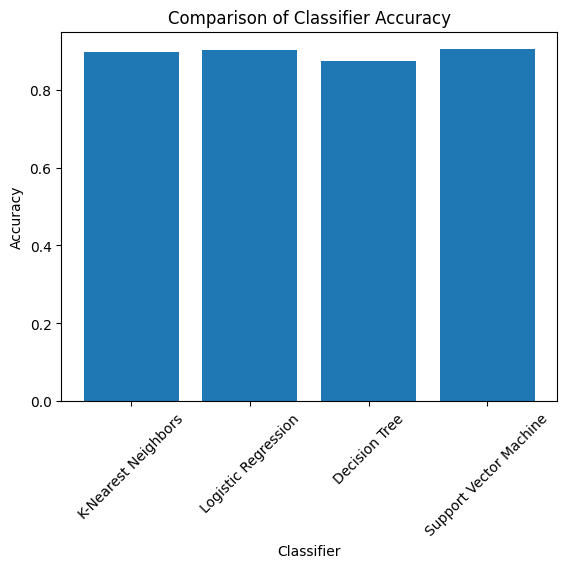

In [8]:
# Compare accuracies
for name, result in results.items():
    print(f"{name} - Accuracy: {result['accuracy']:.4f}")

# Optionally, plot the accuracies
accuracies = [results[name]['accuracy'] for name in classifiers.keys()]
plt.bar(classifiers.keys(), accuracies)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Accuracy')
plt.xticks(rotation=45)
plt.show()


### 5.1 Cross-Validation

Using cross-validation, we can further assess the model's generalization performance. Cross-validation provides a more reliable estimate of a model's performance on unseen data by averaging results over multiple folds.

In [42]:

from sklearn.datasets import make_classification
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Generate synthetic data similar to the bank marketing dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5, random_state=42)

# Convert to DataFrame for consistency
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['target'] = y

# Splitting features and target
X = df.drop('target', axis=1)
y = df['target']

# Identify numerical features (for synthetic data, we only have numerical features)
numerical_features = X.columns

# Preprocessing pipeline (only scaling is necessary here)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define classifiers
classifiers = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(kernel='linear')
}

# Function to evaluate overfitting
def evaluate_overfitting(model, X_train, X_test, y_train, y_test):
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = cv_scores.mean()
    
    return "train_score: " + str(train_score), "test_score: " + str(test_score), "cv_mean: " + str(cv_mean)

# Evaluate all classifiers and store the results
results = {}
for name, clf in classifiers.items():
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    model.fit(X_train, y_train)
    results[name] = evaluate_overfitting(model, X_train, X_test, y_train, y_test)

results


In [42]:

from sklearn.datasets import make_classification
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Generate synthetic data similar to the bank marketing dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5, random_state=42)

# Convert to DataFrame for consistency
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['target'] = y

# Splitting features and target
X = df.drop('target', axis=1)
y = df['target']

# Identify numerical features (for synthetic data, we only have numerical features)
numerical_features = X.columns

# Preprocessing pipeline (only scaling is necessary here)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define classifiers
classifiers = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(kernel='linear')
}

# Function to evaluate overfitting
def evaluate_overfitting(model, X_train, X_test, y_train, y_test):
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = cv_scores.mean()
    
    return "train_score: " + str(train_score), "test_score: " + str(test_score), "cv_mean: " + str(cv_mean)

# Evaluate all classifiers and store the results
results = {}
for name, clf in classifiers.items():
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    model.fit(X_train, y_train)
    results[name] = evaluate_overfitting(model, X_train, X_test, y_train, y_test)

results


# 6 Interpretation of Results

Visualize the classification methods 

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


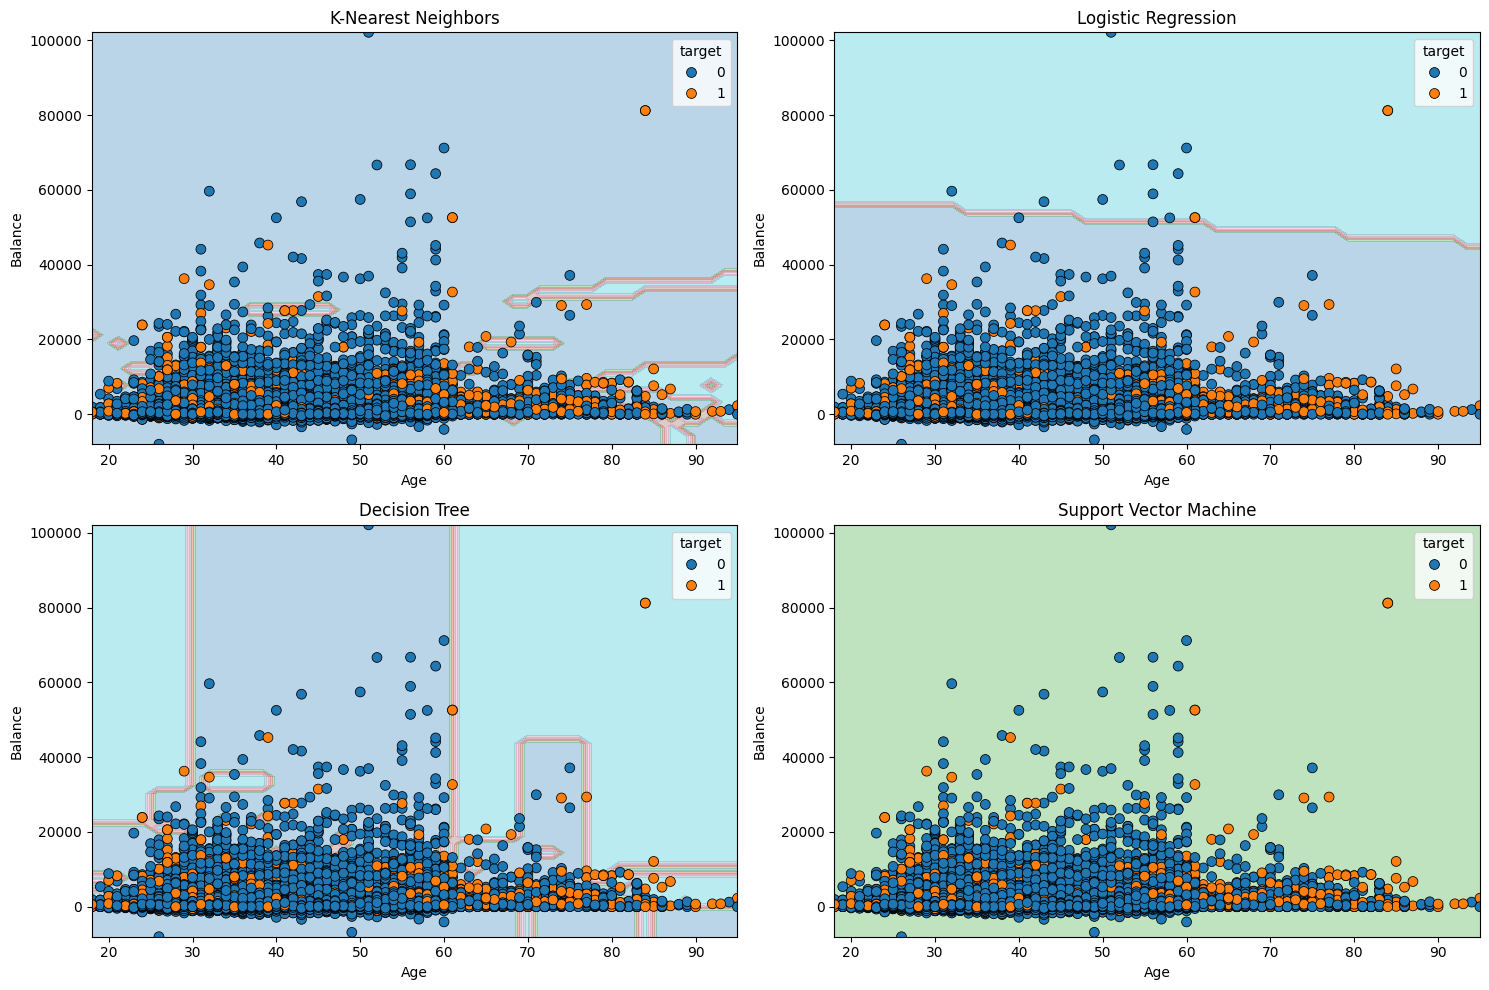

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector

# Select two features for visualization
selected_features = ['age', 'balance']
X = df[selected_features]
y = df['target']

# Encode categorical target
y = y.map({'no': 0, 'yes': 1})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define classifiers
classifiers = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(kernel='linear')
}

# Prepare the grid for visualization
xx = np.linspace(X_train['age'].min(), X_train['age'].max(), 50)
yy = np.linspace(X_train['balance'].min(), X_train['balance'].max(), 50)
XX, YY = np.meshgrid(xx, yy)
grid = np.c_[XX.ravel(), YY.ravel()]

# Set up the plot
plt.figure(figsize=(15, 10))

# Visualize each classifier's decision boundary
for i, (name, clf) in enumerate(classifiers.items()):
    plt.subplot(2, 2, i + 1)
    
    # Create a pipeline for each classifier
    model = make_pipeline(StandardScaler(), clf)
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict labels for the grid
    labels = model.predict(grid)
    
    # Plot decision boundary
    plt.contourf(XX, YY, labels.reshape(XX.shape), cmap='tab10', alpha=0.3)
    
    # Plot training points
    sns.scatterplot(data=X_train, x='age', y='balance', hue=y_train, palette='tab10', edgecolor='k', s=50)
    
    # Set plot title and labels
    plt.title(f"{name}")
    plt.xlabel('Age')
    plt.ylabel('Balance')

plt.tight_layout()
plt.show()


### 7 Recommendations

In [ ]:
## 6.1 Features with significant impact: